# Analyse des enzymes de méthylation dans le cancer du sein métastatique

Dans cette partie, nous allons évaluer le risque de développement de métastases dans le cancer du sein

Le risque de métastases peut être mesuré dans chaque échantillon du cancer du sein à l’aide de la signature moléculaire déjà connues, appelée GEC (Gene Expression Classifier) et basée sur l’expression de 5 gènes : DNMT3B, MCM10, EXO1, CENPF, CENPE.

## Import des données

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from io import StringIO
import sys
# from adjustText import adjust_text
# import random

In [4]:
# Fichier qui donne le type de cancer activé pour chaque échnantillon
cancer = pd.read_csv('data/Breast_cancer_subtypes_samples.csv',sep=';')

In [5]:
# Expressions data 
GSE21653 = pd.read_csv('data/expression_data_GSE21653_GSE21653_log_expression_266_samples_21887_genes.csv',sep=';')
Miller = pd.read_csv('data/expression_data_Miller-2005_Miller-2005_log_expression_251_samples_14145_genes.csv',sep=';')
Naderi_Caldas = pd.read_csv('data/expression_data_Naderi-Caldas-2007_Naderi-Caldas-2007_log_expression_242_samples_14366_genes.csv',sep=';')
E_MTAB_365 = pd.read_csv('data/expression_data_probreast_microarrays_E-MTAB-365_log_expression_1190_samples_23035_genes.csv',sep=';')
GSE25066 = pd.read_csv('data/expression_data_probreast_microarrays_GSE25066_log_expression_508_samples_13815_genes.csv',sep=';')
GSE42568 = pd.read_csv('data/expression_data_probreast_microarrays_GSE42568_log_expression_121_samples_23035_genes.csv',sep=';')
TCGA_BRCA = pd.read_csv('data/expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1250_samples_42851_genes.csv',sep=';')
Yau = pd.read_csv('data/expression_data_Yau-2010_Yau-2010_log_expression_683_samples_8791_genes.csv',sep=';')

In [6]:
# Annotations biocliniques
GSE21653_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx')
GSE25066_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE25066.xlsx')
GSE42568_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE42568.xlsx')
TCGA_BRCA_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_TCGA-BRCA.xlsx')
Naderi_Caldas_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Naderi-Caldas-2007.xlsx')
Yau_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Yau-2010.xlsx')
Miller_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.02_Miller-2005.xlsx')
E_MTAB_365_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_E-MTAB-365.xlsx')

In [7]:
# Import des 35 KDM
with open("genes_interets/KDM.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMT = pd.DataFrame({'id': id, 'nom_gene': nom_gene, 'type': np.repeat("KMT",len(id))}) # , 'type': np.repeat("KMT",len(id))


# Import des 109 KMT
with open("genes_interets/KMT.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KDM = pd.DataFrame({'id': id, 'nom_gene': nom_gene, 'type': np.repeat("KDM",len(id))}) # , 'type': np.repeat("KDM",len(id))

# Import des 461 KMB
with open("genes_interets/KMB.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMB = pd.DataFrame({'id': id, 'nom_gene': nom_gene, 'type': np.repeat("KMB",len(id))}) # , 'type': np.repeat("KMB",len(id))

In [8]:
GI = pd.concat([KMT,KDM,KMB])
GI.head()

,id,nom_gene,type
0,65990,ANTKMT,KMT
1,55870,ASH1L,KMT
2,134145,ATPSCKMT,KMT
3,144233,BCDIN3D,KMT
4,154743,BMT2,KMT


Nous ajouter les 5 gènes qui constituent le score GEC dans le tableau contenant les gène d'intérêts 

In [9]:
gene_GEC = pd.concat([E_MTAB_365[E_MTAB_365.gene_symbol.isin(["MCM10", "EXO1", "CENPF", "CENPE"])][['id_gene', 'gene_symbol']], 
                      pd.DataFrame({'type': [np.nan] * 4})], 
                      axis = 1)
gene_GEC.columns = ['id', 'nom_gene', 'type']

In [10]:
GI = pd.concat([GI, gene_GEC])

In [11]:
GSE21653 = GSE21653[GSE21653["id_gene"].isin(GI.id.values)]
Miller = Miller[Miller["id_gene"].isin(GI.id.values)]
Naderi_Caldas = Naderi_Caldas[Naderi_Caldas["id_gene"].isin(GI.id.values)]
E_MTAB_365 = E_MTAB_365[E_MTAB_365["id_gene"].isin(GI.id.values)]
GSE25066 = GSE25066[GSE25066["id_gene"].isin(GI.id.values)]
GSE42568 = GSE42568[GSE42568["id_gene"].isin(GI.id.values)]
TCGA_BRCA = TCGA_BRCA[TCGA_BRCA["id_gene"].isin(GI.id.values)]
Yau = Yau[Yau["id_gene"].isin(GI.id.values)]

In [12]:
E_MTAB_365[E_MTAB_365.gene_symbol.isin(["DNMT3B", "MCM10", "EXO1", "CENPF", "CENPE"])]

,id_gene,gene_symbol,CIT_DSCGH_001,CIT_DSCGH_002,CIT_DSCGH_003,CIT_DSCGH_004,CIT_DSCGH_005,CIT_DSCGH_006,CIT_DSCGH_007,CIT_DSCGH_008,...,CIT_DSOA_528,CIT_DSOA_529,CIT_DSOA_530,CIT_DSOA_531,CIT_DSOA_532,CIT_DSOA_533,CIT_DSOA_534,CIT_DSOA_535,CIT_DSOA_536,CIT_DSOA_537
778,1062,CENPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.143413,4.157071,4.745037,6.035371,5.547391,5.580004,4.541093,4.671794,4.366655,4.043462
779,1063,CENPF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.618008,2.747364,2.821885,3.510380,2.950692,3.021321,2.934386,3.219552,2.694581,2.851549
1265,1789,DNMT3B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.574982,6.406496,5.813964,6.089682,5.744101,5.300636,5.752063,6.618485,5.042237,5.656535
6155,9156,EXO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.884040,6.267389,5.520775,5.867319,5.496897,5.250878,5.334969,6.109934,5.479028,5.260840
11033,55388,MCM10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.275589,6.807269,5.032383,6.120611,5.016474,4.517162,4.896410,5.754546,4.339487,4.090181


In [13]:
# Ces commandes permettent de rajouter le type de gène dans les différents jeux de données
GSE21653 = GSE21653.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
Miller = Miller.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
Naderi_Caldas = Naderi_Caldas.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
E_MTAB_365 = E_MTAB_365.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
GSE25066 = GSE25066.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
GSE42568 = GSE42568.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
TCGA_BRCA = TCGA_BRCA.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)
Yau = Yau.merge(GI,how='left',left_on = 'id_gene', right_on='id').drop(['id', 'nom_gene'], axis=1)

### Le score GEC 

Le score GEC est souvent associé au développement de métastases. Nous pouvons le retrouver dans les jeux de données "annotations biocliniques" ! Cependant, il n'est pas disponible dans tous les jeux de données. Il n'est pas disponible dans : 
- GSE21653
- Yau
- Miller

In [14]:
E_MTAB_365_EG['3-GEC']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1185    0.0
1186    0.0
1187    3.0
1188    0.0
1189    0.0
Name: 3-GEC, Length: 1190, dtype: float64

Le risque de métastases peut être mesuré dans chaque échantillon du cancer du sein à l’aide de la signature moléculaire déjà connues, appelée GEC (Gene Expression Classifier) et basée sur l’expression de 5 gènes : DNMT3B, MCM10, EXO1, CENPF, CENPE.

In [15]:
E_MTAB_365[E_MTAB_365.gene_symbol.isin(["DNMT3B", "MCM10", "EXO1", "CENPF", "CENPE"])]

,id_gene,gene_symbol,CIT_DSCGH_001,CIT_DSCGH_002,CIT_DSCGH_003,CIT_DSCGH_004,CIT_DSCGH_005,CIT_DSCGH_006,CIT_DSCGH_007,CIT_DSCGH_008,...,CIT_DSOA_529,CIT_DSOA_530,CIT_DSOA_531,CIT_DSOA_532,CIT_DSOA_533,CIT_DSOA_534,CIT_DSOA_535,CIT_DSOA_536,CIT_DSOA_537,type
11,1062,CENPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.157071,4.745037,6.035371,5.547391,5.580004,4.541093,4.671794,4.366655,4.043462,NaN
12,1063,CENPF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.747364,2.821885,3.510380,2.950692,3.021321,2.934386,3.219552,2.694581,2.851549,NaN
27,1789,DNMT3B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.406496,5.813964,6.089682,5.744101,5.300636,5.752063,6.618485,5.042237,5.656535,KMB
128,9156,EXO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.267389,5.520775,5.867319,5.496897,5.250878,5.334969,6.109934,5.479028,5.260840,NaN
360,55388,MCM10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.807269,5.032383,6.120611,5.016474,4.517162,4.896410,5.754546,4.339487,4.090181,NaN


Le score GEC varie entre 0 et 5, il compte combien parmi les 5 gènes (ci-dessus) sont activés dans un échantillon du cancer du sein.

In [16]:
E_MTAB_365_EG[['id_sample', '3-GEC']]

,id_sample,3-GEC
0,CIT_DSCGH_001,NaN
1,CIT_DSCGH_002,NaN
2,CIT_DSCGH_003,NaN
3,CIT_DSCGH_004,NaN
4,CIT_DSCGH_005,NaN
...,...,...
1185,CIT_DSOA_533,0.0
1186,CIT_DSOA_534,0.0
1187,CIT_DSOA_535,3.0
1188,CIT_DSOA_536,0.0


Par exemple dans le jeu de données ci-dessus, nous remarquons qu'il y 3 gènes activés parmi les 5 dans l'échantillon **CIT_DSOA_535**

Le score GEC est significativement associé à la survie globale des patients (dans les datasets où les données de survie globale OS sont disponibles) ainsi qu’au risque de rechute de la maladie (données de survie DFS disponibles dans tous les datasets). Il est également associé au risque de métastases. 
**Conclusion : La signature GEC peut être utilisée comme une signature de risque de métastases dans le cancer du sein.**

### Identifier les enzymes de méthylation activés dans le cancer métastatique


In [91]:
df = pd.read_pickle('data/volcano.pkl')
df = df[df['gene'].isin(GI['nom_gene'].values)]
df = df.merge(GI, how='left', left_on='gene', right_on='nom_gene').drop(['id', 'nom_gene'], axis = 1)
df.columns = ['gene', 'dataset', 'soustype', 'LOGfc', 'FC', 'F', 'pvalue', 'FDR', 'groupe_ezyme']

In [92]:
FDRlog10 = -np.log10(df.FDR.astype(float))
df = pd.concat([df, FDRlog10], axis = 1)
df.columns = ['gene', 'dataset', 'soustype', 'LOGfc', 'FC', 'F', 'pvalue', 'FDR', 'groupe_ezyme','FDRlog10']

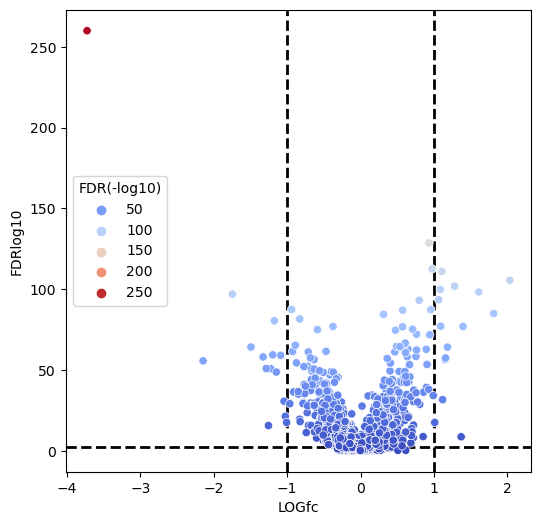

In [60]:
plt.figure(figsize = (6,6))

ax = sns.scatterplot(data = df[df.dataset == "TCGA-BRCA"], x = 'LOGfc', y = 'FDRlog10',hue='FDRlog10', palette='coolwarm')

ax.axhline(2, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(1, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(-1, zorder = 0, c = 'k', lw = 2, ls = '--')  

plt.legend(title='FDR(-log10)')

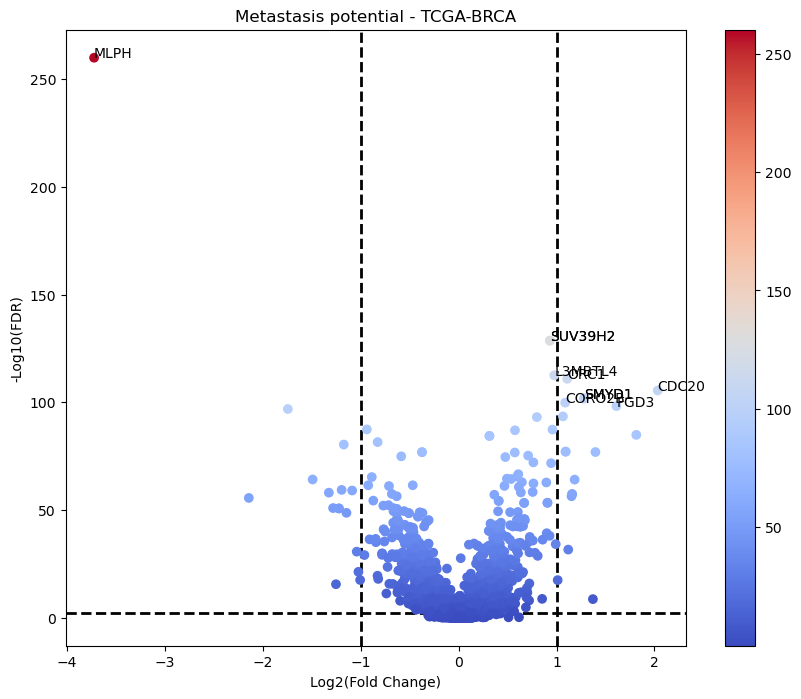

In [95]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data= df[df.dataset == "TCGA-BRCA"], x='LOGfc', y='FDRlog10', c='FDRlog10', cmap='coolwarm')
plt.colorbar(scatter)
plt.title('Metastasis potential - TCGA-BRCA')
plt.xlabel('Log2(Fold Change)')
plt.ylabel('-Log10(FDR)')

FDRlog10 = df[df.dataset == "TCGA-BRCA"]['FDRlog10'].sort_values(ascending=False).iloc[:10]
top10 = df.iloc[FDRlog10.index]

for i in range(top10.shape[0]):
    plt.annotate(top10.gene.iloc[i], (top10.LOGfc.iloc[i], top10.FDRlog10.iloc[i]))


plt.axhline(2, zorder = 0, c = 'k', lw = 2, ls = '--')
plt.axvline(1, zorder = 0, c = 'k', lw = 2, ls = '--')
plt.axvline(-1, zorder = 0, c = 'k', lw = 2, ls = '--')  

plt.show()

In [102]:
# Dans la fonction ci-dessous, qui généralise le plot ci-dessus, nous proposons à l'utilisateur de saisir en entrée le dataset 
# mais aussi le groupe d'enzymes auquel il appartient (KMT, KMB ou KDM)
def metastasis_plot(dataset, group = None):
    if group == None:
        donnees = df[df.dataset == dataset]
    else: 
        donnees = df[(df.dataset == dataset) & (df.groupe_ezyme == group)]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data = donnees, x='LOGfc', y='FDRlog10', c='FDRlog10', cmap='coolwarm')
    plt.colorbar(scatter)
    plt.title(f'Metastasis potential - {dataset}')
    plt.xlabel('Log2(Fold Change)')
    plt.ylabel('-Log10(FDR)')

    FDRlog10 = donnees['FDRlog10'].sort_values(ascending=False).iloc[:10]
    top10 = df.iloc[FDRlog10.index]

    for i in range(top10.shape[0]):
        plt.annotate(top10.gene.iloc[i], (top10.LOGfc.iloc[i], top10.FDRlog10.iloc[i]))


    plt.axhline(2, zorder = 0, c = 'k', lw = 2, ls = '--')
    plt.axvline(1, zorder = 0, c = 'k', lw = 2, ls = '--')
    plt.axvline(-1, zorder = 0, c = 'k', lw = 2, ls = '--')  

    plt.show()

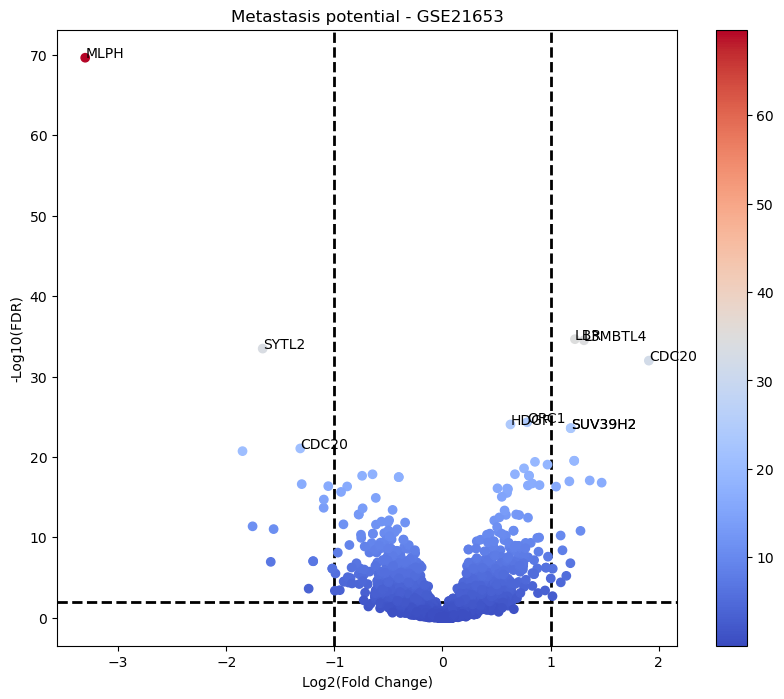

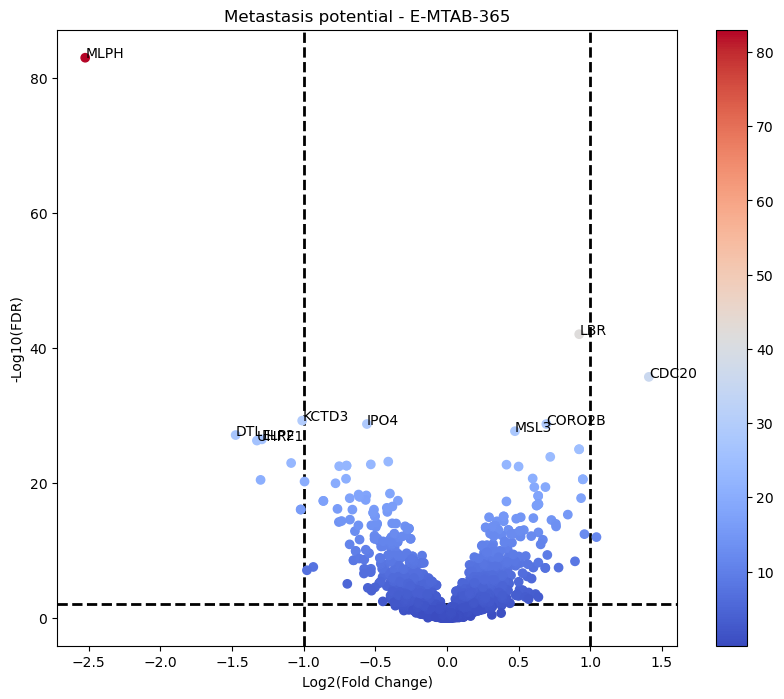

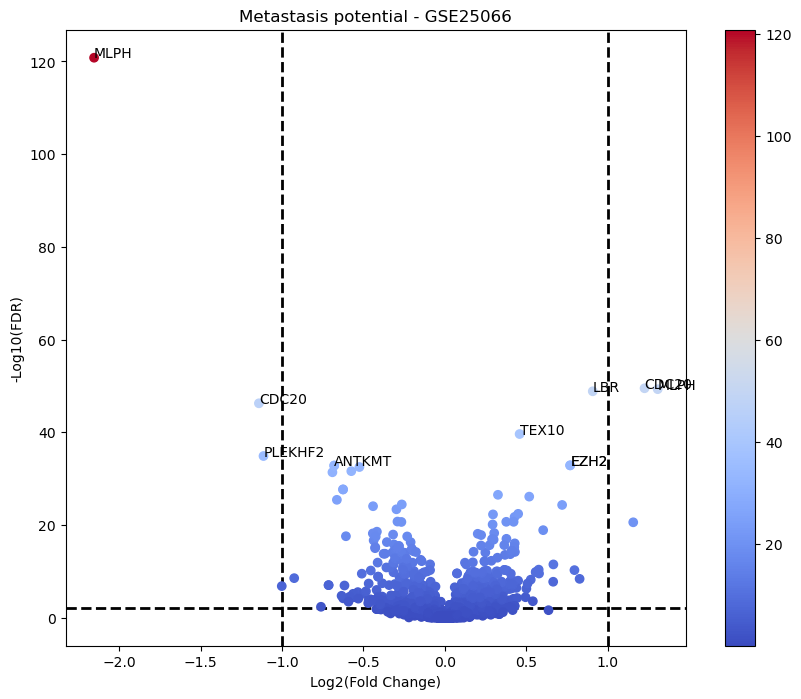

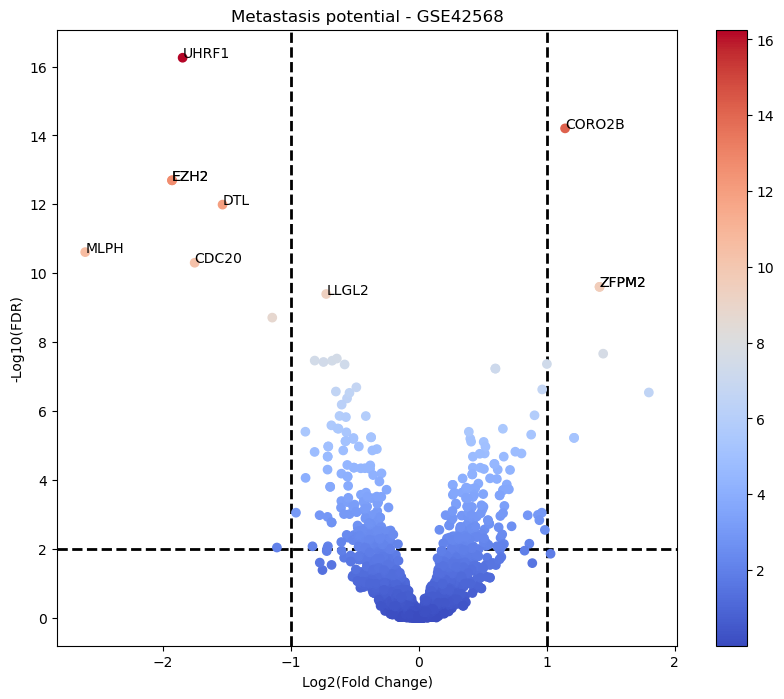

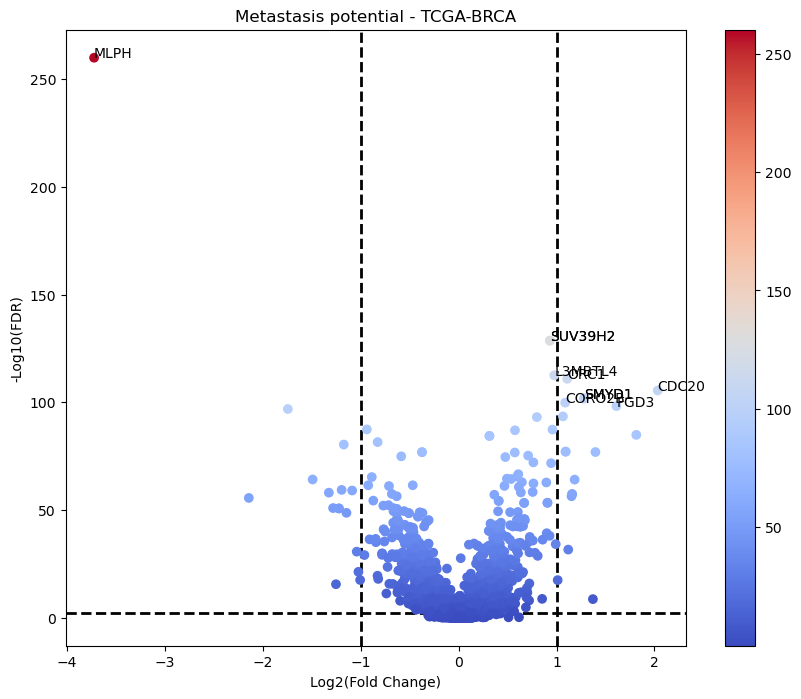

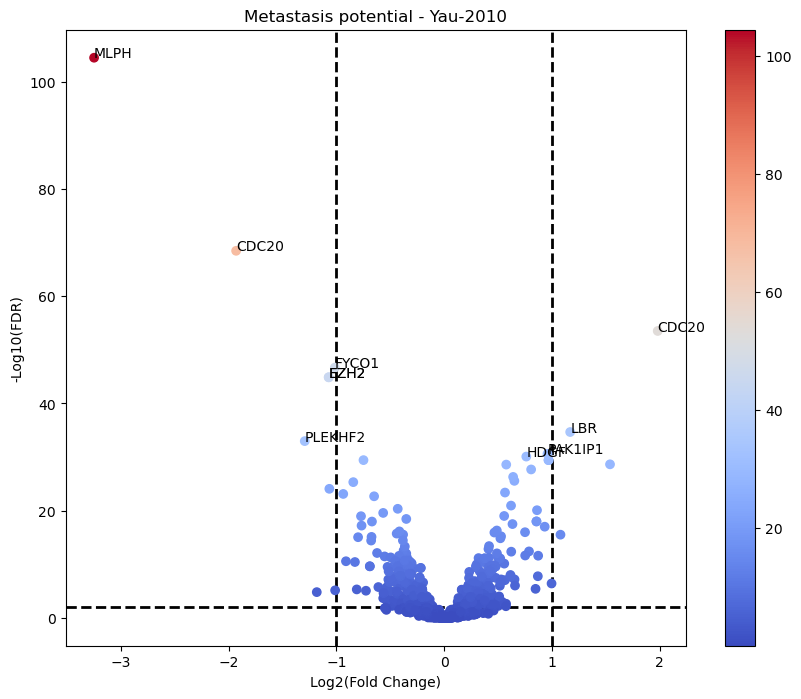

In [105]:
metastasis_plot("GSE21653")
metastasis_plot("E-MTAB-365")
metastasis_plot('GSE25066')
metastasis_plot('GSE42568')
metastasis_plot('TCGA-BRCA')
metastasis_plot('Yau-2010')